In [22]:
using Revise
using ITensors
using ITensorInfiniteMPS

using Statistics
using Plots
using LaTeXStrings
using CurveFit

include("src/TopologicalOrder.jl")
include("src/Entanglement_spectrum.jl");

# Functions 

In [23]:
pathSave = "FiguresNew/"
DefRed = RGB(1., 0.1, 0.26)
DefBlue = RGB(0.0, 0.2, 0.4)
DefYell = RGB(0.93, 0.57, 0.13)
DefGreen = RGB(0., 0.56, 0.)
DefCyan  = RGB(0.0, 0.81, 0.82)
DefPurp = RGB(0.6, 0.33, 0.73)

DefColors = [DefRed, DefBlue, DefYell, DefGreen, DefPurp, DefCyan]

setMark  = [:circle, :diamond, :rect, :utriangle, :dtriangle, :pentagone];

function saveFig(namesave::String, fig)
    pathSaveL = "FiguresNew/"
    Plots.png(fig, pathSaveL*namesave)
    Plots.svg(fig, pathSaveL*namesave)
end
    

saveFig (generic function with 1 method)

## Data loading functions

In [24]:
function pitick(start, stop, denom; mode=:text)
    a = Int(cld(start, π/denom))
    b = Int(fld(stop, π/denom))
    tick = range(a*π/denom, b*π/denom; step=π/denom)
    ticklabel = piticklabel.((a:b) .// denom, Val(mode))
    tick, ticklabel
end

function piticklabel(x::Rational, ::Val{:text})
    iszero(x) && return "0"
    S = x < 0 ? "-" : ""
    n, d = abs(numerator(x)), denominator(x)
    N = n == 1 ? "" : repr(n)
    d == 1 && return S * N * "π"
    S * N * "π/" * repr(d)
end

function piticklabel(x::Rational, ::Val{:latex})
    iszero(x) && return L"0"
    S = x < 0 ? "-" : ""
    n, d = abs(numerator(x)), denominator(x)
    N = n == 1 ? "" : repr(n)
    d == 1 && return L"%$S%$N\pi"
    L"%$S\frac{%$N\pi}{%$d}"
end

piticklabel (generic function with 2 methods)

In [25]:
function replaceTranslator(ψ1::InfiniteMPS, translator)
    ψ = deepcopy(ψ1)
    return InfiniteMPS(CelledVector(ψ.data.data, translator), ψ.llim, ψ.rlim, ψ.reverse)
end

function replaceTranslator(ψ1::InfiniteCanonicalMPS, translator)
    ψ = deepcopy(ψ1)
    return InfiniteCanonicalMPS(replaceTranslator(ψ.AL, translator), replaceTranslator(ψ.C, translator), replaceTranslator(ψ.AR, translator))
end

function fermion_momentum_translater_General(i::Index, n::Int64, N)
    ts = tags(i)
    translated_ts = translatecelltags(ts, n)
    new_i = replacetags(i, ts => translated_ts)
    for j in 1:length(new_i.space)
    ch = new_i.space[j][1][1].val
    mom = new_i.space[j][1][2].val
    new_i.space[j] = Pair(QN(("Nf", ch ), ("NfMom", mom + n*N*ch)),  new_i.space[j][2])
    end
    return new_i
  end;

fermion_momentum_translater_four(i::Index, n::Int64) = fermion_momentum_translater_General(i, n, 4)
fermion_momentum_translater_six(i::Index, n::Int64) = fermion_momentum_translater_General(i, n, 6)

fermion_momentum_translater_six (generic function with 1 method)

In [46]:
function LoadData(RootPattern::Vector{Int64}, setMeasure, FixParam::Float64, χmax::Int64, χ::Int64, type::String, measure::String; maxIters=100, noise=0.0, flag=false)
    DictR = Dict()
    path = "Data/TransitionInfiniteCylinder/$(type)/"

    
    setE = []
    setPsi = InfiniteCanonicalMPS[]
    setErr =[]
    setEntr =[]
    gapTag = gap ? "gap_" : ""
    translatorLoc = length(RootPattern) == 4 ? fermion_momentum_translater_four : fermion_momentum_translater_six

    setMeas = []
    println(χ)
    for (ind, Meas) in enumerate(setMeasure)
        front = gapTag*"rp$(RootPattern_to_string(RootPattern))_chiMax$(χmax)_"
        midName  = measure == "DT" ?  "Ly$(round(Meas, digits=5))_theta$(round(FixParam, digits=5))" : "Ly$(round(FixParam, digits=5))_theta$(round(Meas, digits=5))"
        endName = "_maxiters$(maxIters)_chi$(χ)_alpha$(noise).jld2"
        
        openName = path*front*midName*endName
     
        el = measure == "DT" ? "L" : "θ" 
        # println("Loading $el = $(round(Meas, digits=5))")
          
        if !isfile(openName)
            newFront = gapTag*"rp$(RootPattern_to_string(RootPattern))_chiMax1024_"
            if isfile(path*newFront*midName*endName)
                mv(path*newFront*midName*endName, openName)
                println("move files, relaod")
                continue

            end
            
            println("missing $Meas at index $ind")
            continue
        end

        append!(setMeas, Meas)
        jldopen(openName, "r") do file
            ψLoc = file["dmrgStruct"].ψ
            push!(setPsi, replaceTranslator(ψLoc, translatorLoc))
            append!(setE, file["energies"][end])
            append!(setErr,file["errors"])
            append!(setEntr, file["entropies"][end])
        end
    end
    
    DictR["Psi"] = setPsi
    DictR["Energy"] = setE
    DictR["Errors"] = setErr
    DictR["Entropy"] = setEntr

    return DictR, setMeas
end;

function loadData(type::String, setRP)
    setDataTemp = Vector{Dict}(undef, length(setRP))
    setVariational = type=="phase" ?  LinRange(θmin, θmax, Nθ) : LinRange(Lmin, Lmax, NL)
    setMeas = []

    for (ind, rp) in enumerate(setRP)
        if type != "phase"
            setDataTemp[ind], setMeas = LoadData(rp, setVariational, θ, χmax, χ, typeInt, "DT"; flag=flag)
        else
            setDataTemp[ind], setMeas = LoadData(rp, setVariational, L, χmax, χ, typeInt, "PP"; flag=flag)
        end
    end
    println("Sucessfuly load the data")
    return setDataTemp, setMeas
end

loadData (generic function with 1 method)

## Plotting functions and parameters

In [47]:
function GeneralSinglePlot(setX::Vector{Float64}, setY::Vector{Float64}, meas::LaTeXString, xlabel::LaTeXString, ylabel::LaTeXString; showLab::Bool=false, c=DefGreen, type="scatter", ms=4.5, ls=2., mk=:circle, posLeg=:topright)

    fig = plot()
    if type == "scatter"
        scatter!(fig, 
            setX, 
            setY, 
            primary=showLab, 
            label=meas, 
            color = c, 
            markersize= ms,
            marker=mk,
            Legend=posLeg
        )
    else
        plot!(fig, 
            setX, 
            setY, 
            primary=showLab, 
            label=meas, 
            color = c, 
            markersize= ms,
            marker=mk,
            linewidth=ls,
            Legend=posLeg
        )
    end

    xlabel!(xlabel)
    ylabel!(ylabel)

    return fig
end


function GeneralPlotArray(
        setDiff::Vector{Int64}, setX::Vector{Vector{Float64}}, setY::Vector{Vector{Float64}}, meas::Vector{LaTeXString},
        xlabel::LaTeXString, ylabel::LaTeXString; showLab::Bool=false, markers=setMark,
        c=DefColors, typeP="scatter", ms=4.5, ls=2., mk=:circle, posLeg=:bottomright, scaleL=:identity
    )
    figL = plot()

    for (ind, El) in enumerate(setDiff)
    
        if typeP == "scatter"
            scatter!(figL, 
                setX[ind], 
                setY[ind], 
                primary=showLab, 
                label=meas[ind], 
                color = c[ind], 
                markersize= ms,
                marker=setMark[ind],
                legend=posLeg, 
                yaxis=scaleL
            )
        else
            plot!(figL, 
                setX[ind], 
                setY[ind], 
                primary=showLab, 
                label=meas[ind], 
                color = c[ind], 
                markersize= ms,
                marker=mk,
                linewidth=ls,
                yaxis=scaleL,
                legend=posLeg
            )
        end
    
        xlabel!(xlabel)
        ylabel!(ylabel)
    
    end

    return figL
end

GeneralPlotArray (generic function with 1 method)

### Correlation length

In [28]:
function PlotCorrelationLength(setThL::Vector{Any}, setψL::Array{InfiniteCanonicalMPS})
    setXi = CorrelationLength(setψL)
    setXi = convert(Vector{Float64}, setXi)
    figL = GeneralSinglePlot(setThL, setXi, "correlation length", L"$\theta$", L"$\xi_{corr}$";)
    
    display(figL)
end
    
function PlotCorrelationLength(setChi::Vector{Int64}, setθ, setRP, setLeg; chiMax=4096)
    
    MatrixXi = Vector{Vector{Float64}}(undef, length(setChi))
    MatrixTh = Vector{Vector{Float64}}(undef, length(setChi))
    
    for (ind, chi) in enumerate(setChi)
        setDict, setNθ = LoadData(setRP[1], setθ, L, chiMax, chi, typeInt, "PP"; flag=false)
        MatrixXi[ind] = CorrelationLength(setDict["Psi"])
        MatrixTh[ind] = setNθ
    end

    figL = GeneralPlotArray(setChi, MatrixTh, MatrixXi, setLeg, L"$\theta$", L"$\xi_{corr}$"; showLab=true, posLeg=:top)
    
    return figL
end

function PlotCorrelationLength(setL::Vector{Any}, setDT::Vector{Dict})
    setRP = Any[1100, 1010]
    setXi =convert(Vector{Vector{Float64}}, [[CorrelationLength(setDT[i]["Psi"][j]) for j in 1:length(setL)] for i=1:2])
    MatrixL = convert(Vector{Vector{Float64}},  [1 ./setL, 1 ./setL])
    @show MatrixL
    @show typeof(MatrixL)
    figL = GeneralPlotArray(setRP, MatrixL, setXi, "", L"$L_x$", L"$\xi_{corr}$"; showLab=true, posLeg=:top)
    display(figL)
    return figL
end

PlotCorrelationLength (generic function with 3 methods)

### Phase portait

In [29]:
function Energy(setThL::Array{Any}, setDataLoc::Array{Dict})
    setE = setDataLoc[1]["Energy"] .- -0.5
    return GeneralSinglePlot(setThL, setE, L"Energy", L"$\theta$", L"E"; showLab=true, posLeg=:top)
end

function Entropy(setThL::Array{Any}, setDataLoc::Array{Dict}; N= 0)
    setS = entropy(setDataLoc[1]["Psi"], N)
 
    return GeneralSinglePlot(setThL, setS, L"Entropy", L"$\theta$", L"S"; showLab=true, posLeg=:topleft)
end

function Fidelity(setThL::Array{Any}, setDataLoc::Array{Dict})
    Newsetθ, setFi = Fidelity(setDataLoc[1]["Psi"], setThL)
    ylabelL = L"$\langle \psi(\theta)| \psi(\theta + \delta \theta)\rangle$"
    Newsetθ  = convert(Vector{Any}, Newsetθ)
    setFi = convert(Vector{Float64}, setFi)
    return GeneralSinglePlot(Newsetθ, setFi, L"Fidelity", L"$\theta$", ylabelL; showLab=true, posLeg=:bottom)
end


function Energy(setChi::Vector{Any})

    MatrixE = Array{Array{Any}}(undef, length(setChi))
    MatrixTh = Array{Array{Any}}(undef, length(setChi))

    for (ind, chi) in enumerate(setChi)
        setDict, setNθ = LoadData(setRP[1], setθ, L, χmax, chi, typeInt, "PP"; flag=false)

        MatrixE[ind] = setDict[1]["Energy"] .- -0.5
        MatrixTh[ind] = setNθ
    end

    return GeneralPlotArray(setChi, MatrixTh, MatrixS, "Chi=", L"$\theta$", L"E";showLab=true, posLeg=:top)
    
end

function Entropy(setChi::Vector{Any})

    MatrixS = Array{Array{Any}}(undef, length(setChi))
    MatrixTh = Array{Array{Any}}(undef, length(setChi))

    for (ind, chi) in enumerate(setChi)
        setDict, setNθ = LoadData(setRP[1], setθ, L, χmax, chi, typeInt, "PP"; flag=false)

        MatrixS[ind] = setDict[1]["Entropy"]
        MatrixTh[ind] = setNθ
    end

    return GeneralPlotArray(setChi, MatrixTh, MatrixS, "Chi=", L"$\theta$", L"S";showLab=true, posLeg=:topleft)
    
end
    
function Fidelity(setChi::Vector{Any})
    
    MatrixFi = Array{Array{Any}}(undef, length(setChi))
    MatrixTh = Array{Array{Any}}(undef, length(setChi))
    ylabelL = L"$\langle \psi(\theta)| \psi(\theta + \delta \theta)\rangle$"
    for (i, chi) in enumerate(setX)

        setDict, setT = LoadData(setRP[1], setθ, L, χmax, chi, typeInt, "PP"; flag=false)
        Newsetθ, setFi = Fidelity(setDict["Psi"], setT)

        MatrixFi[ind] = setFi
        MatrixTh = Newsetθ
    end 

    return GeneralPlotArray(setChi, MatrixTh, MatrixFi, "Chi=", L"$\theta$", ylabelL;showLab=true, posLeg=:bottom)
end

Fidelity (generic function with 3 methods)

In [30]:
function PhasePortait(setTh_loc::Array{Any}, setData_loc::Array{Dict})

    p = [Energy(setTh_loc, setData_loc), Entropy(setTh_loc, setData_loc), Fidelity(setTh_loc, setData_loc)];
    
    l = @layout [a; b; c]
    figUn = plot(p..., layout=l, size=(1000, 850))

    return figUn
end

PhasePortait (generic function with 1 method)

### Entanglement Spectrum

In [31]:
function plot_entanglement_spectrum(psi, rp; setcol=DefColors)
  
  D = compute_entanglement_spectrum(psi)
  
    
  # c = reverse(palette(:rainbow))
  
    
  pEnt = []
    
    for n = 1:4
    
      cut = 0
      if n==1 
        cut = 2
      elseif n==2
        cut = 4
      elseif n==3
        cut = 2
      end

      E = Sector_Entanglement_Spectrum(D[n], cut)
  
      push!(pEnt, scatter(E["K"], E["Eta"], 
            marker=:hline, 
            markersize=5, 
            color=setcol[n],  
            primary=false, 
            xlabel=L"$K$", 
            ylabel=L"$\xi$", 
            # ylims=(0,25),
            markerstrokewidth=2, 
            # xlims=(-10, 40)
          )
      )
    end
  
  
  fig = plot(pEnt..., layout=(2,2), plot_title=L"%$rp")
  display(fig)
  return fig
end

function singleEntanglementSpectrum(psi, sector; c=DefRed)
  
  D = compute_entanglement_spectrum(psi)

  cut = 0
  if sector==1 
    cut = 2
  elseif sector==2
    cut = 4
  elseif sector==3
    cut = 2
  end

  E = Sector_Entanglement_Spectrum(D[sector], cut)
  fig = plot()
  scatter!(E["K"], E["Eta"], 
        marker=:hline, 
        markersize=5, 
        color=c,  
        primary=false, 
        xlabel=L"$K$", 
        ylabel=L"$\xi$", 
        ylims=(0,25),
        markerstrokewidth=2, 
        xlims=(-10, 60)
  )
  
  display(fig)
  return fig
end
  
function plot_entanglementSingle(psi, T, N, leg;  cd=DefRed, flag=false)
  D = compute_entanglement_spectrum(psi)
  E = Sector_Entanglement_Spectrum(D[4], N)
  
  fig = plot()
  scatter!(fig, E["K"], E["Eta"], 
        marker=:hline, 
        markersize=5, 
        linewidth=4, 
        color=cd,
        label=leg,
        legend =:bottomright,
        xlabel=L"$K$", 
        ylabel=L"$\xi$", 
        ylims=(0,15),
        markerstrokewidth=2
  )
  flag && xlims!(-5,30)
  return fig
end;
  

In [32]:
function plotAllEnt(setData, i, setM;indexlook = -1)
    setPsi = setData[i]["Psi"]
    fig = plot()
    for (ind, M) in enumerate(setM)
        if indexlook != -1 && indexlook != ind 
            continue
        end
        rp = i== 1 ? 1100 : 1010
        fig = plot_entanglement_spectrum(setPsi[ind], rp)

    end
    return fig 
end;

function plotReprPhase(setIndex, Ly::Float64)
    setPsi = setData[1]["Psi"]
    for ind in setIndex
        
        plot_entanglement_spectrum(setPsi[ind], setθ[ind], Ly)
    end
end;

function plotReprPhase(setPsi, setTh, N::Int64; setLeg=[L"Pf", L"Pi-I", L"R", L"Pi-II"])
    
    p=[]
    for (i, psi) in enumerate(setPsi)
        flagL = i==-1 ? true : false
        push!(p, plot_entanglementSingle(psi, setTh[i], N, setLeg[i]; cd=DefColors[i], flag=flagL))
    end
    l = @layout [a b; c d]
    
    fig = plot(p...)

    display(fig)
    return fig
end;

### Density

In [33]:
function DensityState(setDiff::Vector{Int64}, setPsi::Vector{InfiniteCanonicalMPS}, type::String; sites=1:nsites(psi), indPsi=1, setLeg=[L"Pf", L"Pi-I", L"R", L"Pi-II"])

    MatrixStruc = Vector{Vector{Float64}}(undef, length(setDiff))
    MatrixK = Vector{Vector{Float64}}(undef, length(setDiff))

    if type != "bond"

        for (ind, psi) in enumerate(setPsi)
            setN = expect(psi, "N"; sites=sites)
            
            MatrixStruc[ind] =  setN
            MatrixK[ind] = sites  
        end


        return GeneralPlotArray(setDiff, MatrixK, MatrixStruc, setLeg, L"$n$", L"$\langle \hat{n}_n\rangle$"; showLab=true, typeP="plot", ms=0., c=[DefGreen, DefRed, DefYell, DefBlue])
    else

        for (ind, chi) in enumerate(setDiff)
            
            setDict, setNθ = LoadData(setRP[1], setθ, L, χmax, chi, typeInt, "PP"; flag=false)
            psi = setDict["Psi"][indPsi]


            setN =  expect(psi, "N"; sites=sites)

            MatrixStruc[ind] =  setN
            MatrixK[ind] = sites       
        end
        return GeneralPlotArray(setDiff, MatrixK, MatrixStruc, "chi=", L"$n$", L"$\langle \hat{n}_n\rangle$"; showLab=true, typeP="plot", ms=0.)

    end
end

DensityState (generic function with 1 method)

### Pair correlation function

In [34]:
function ITensors.correlation_matrix(psi::InfiniteCanonicalMPS, OP1::AbstractString, OP2::AbstractString; rangeCorr::AbstractRange)

    CorrBasis = correlator(psi, OP1, OP2, rangeCorr, 20)

    CorrelationMatrix= Zeros(length(rangeCorr), length(rangeCorr))


    for i in length(rangeCorr)
        for j in length(rangeCorr)



        end
    end


    return CorrelationMatrix
end

function MultiplyRight(ψ::MPS, eta::ITensor, N)
    ψi = copy(ψ)
    newEL = ψi[N]*eta
    ψi[N] = newEL
    noprime!(ψi)

    ψi /= norm(ψi)

    return ψi
end



function correlator(psi::InfiniteCanonicalMPS, OP1::AbstractString, OP2::AbstractString, rangeLoc::AbstractRange, Neigen::Int64)

    (lambda, LeftEigenSet), (_, RightEigenSet) = EigenStatesTransferMatrix(copy(psi), Neigen; returnEigs=true)


    N0_L = first(rangeLoc)
    N0_R = N0_L + nsites(psi) -1
    Cell_0 = div(first(rangeLoc), nsites(psi))


    O_n = expect(psi, OP1; sites=1:4, L=LeftEigenSet, R=RightEigenSet)
    O_m = expect(psi, OP2; sites=1:4, L=LeftEigenSet, R=RightEigenSet)

    LeftB = LeftEigenSet[1]

    CorrelationElement = zeros(nsites(psi), length(rangeLoc))

    s = [inds(psi[hh])[2] for hh=1:4]
    for i in 1:nsites(psi)

        #Case if the second operator is in the same cell as the first one
        for jj in 1:nsites(psi)
            jj > nsites(psi) && continue


            ψF = psi[Cell(1)]
            ψF[1] *= LeftB
            ψF[nsites(psi)] *= psi.C[nsites(psi)]*RightEigenSet[1]
            ψF /= norm(ψF)
            noprime!(ψF)
            ψU = copy(ψF)
            ψU[i] *= op(OP1, s[i])
            noprime!(ψU)
            ψU[jj] *= op(OP2, s[jj])
            noprime!(ψU)
            CorrelationElement[i, jj] = abs(inner(ψU, ψF))
        end

        #Construct the left block
        ψL = psi[Cell(1)]
        ψL[1] *= LeftB
        noprime!(ψL)



        for j in 1:length(rangeLoc)
            cell_1 = div(j-1, nsites(psi)) + 1
            site_1 = mod(j-1 ,nsites(psi)) + 1

            cell_1 == 1 && continue


            N = floor(abs(i-j)/nsites(psi))


            #Construct the right block
            ψR = psi[Cell(1)]
            ψR[nsites(psi)]*= psi.C[nsites(psi)]*RightEigenSet[1]
            noprime!(ψR)


            ψRop = copy(ψR)
            ψR[site_1] *= op(OP2, s[site_1])
            noprime!(ψR)


            Corr_1 = O_n[i]*O_m[site_1]

            for n in 2:Neigen
                ηᴸ = LeftEigenSet[n]
                ηᴿ = RightEigenSet[n]*psi.C[nsites(psi)]

                ψᴸLoc = MultiplyRight(ψL, ηᴿ, 4)
                ψᴸOpLoc = copy(ψᴸLoc)
                ψᴸOpLoc[i] *= op(OP1, s[i])
                noprime!(ψᴸOpLoc)

                CorrLeft = inner(ψᴸLoc, ψᴸOpLoc)
                ψᴿLoc = MultiplyRight(ψR, ηᴸ, 1)
                ψᴿOpLoc = copy(ψᴿLoc)
                ψᴿOpLoc[site_1] *= op(OP2, s[site_1])
                noprime!(ψᴿOpLoc)

                CorrRight = inner(ψᴿLoc, ψᴿOpLoc)
                Correlation = abs(CorrLeft*CorrRight*(lambda[n]^N))
                CorrelationElement[i, j] = Correlation
            end


        end
    end


    return CorrelationElement
end
# correlator(setData[1]["Psi"][1], "N", "N", -11:12, 5)



correlator (generic function with 1 method)

### Structure factor

In [35]:
function StructureFactor(setDiff::Vector{Int64}, setPsi::Vector{InfiniteCanonicalMPS}, setT::Vector{Float64}, type::String; scale=:identity, setLeg=[L"Pf", L"Pi-I", L"R", L"Pi-II"], χL=χ, Nphi=150, kmax=7., indPsi=1)

    MatrixStruc = Vector{Vector{Float64}}(undef, length(setDiff))
    MatrixK = Vector{Vector{Float64}}(undef, length(setDiff))

    if type != "bond"

        for (ind, psi) in enumerate(setPsi)
            setU, setk = StructureFactor(psi, L, Nphi, setT[ind], "1100", χL; kmax=kmax, nstep=1000)
            
            MatrixStruc[ind] =  setU
            MatrixK[ind] = setk       
        end

        @show scale
        println("fdssdfsdf")
        return GeneralPlotArray(setDiff, MatrixK, MatrixStruc, setLeg, L"$k_x$", L"$\overline{S}(k_x)$";scaleL=scale, showLab=true, typeP="plot", ms=0.)
    else

        for (ind, chi) in enumerate(setDiff)
            
            setDict, setNθ = LoadData(setRP[1], setθ, L, χmax, chi, typeInt, "PP"; flag=false)
            psi = setDict["Psi"][indPsi]


            setS, setk = StructureFactor(psi, L, Nphi, setθ[indPsi], "1100", chi; kmax=kmax, nstep=1000)

            MatrixStruc[ind] =  setS
            MatrixK[ind] = setk       
        end


        return GeneralPlotArray(setDiff, MatrixK, MatrixStruc, setLeg, L"$k_x$", L"$\overline{S}(k_x)$"; scaleL=scale, showLab=true, posLeg=:bottomright, typeP="plot", ms=0.)

    end
end

StructureFactor (generic function with 3 methods)

### Topological Entanglement Entropy

In [36]:
function TEE(setL::Vector{Any}, setDT::Vector{Dict}; N=0, setColor=DefColors[1:2], setColorFit=DefColors[3:4], plotFit=true,  displayFig=true, returnPlot=false)
    
    PlotSet = [entropy(DictRP["Psi"], N) for DictRP in setDT]

    Fit = [linear_fit(setL, S_S) for S_S in PlotSet]
    fig = plot()

    if plotFit
        x = LinRange(0, setL[end], 100)
       setPlotFit = [x.*FitLoc[2] .+ FitLoc[1] for FitLoc in Fit]
       for (i, y) in enumerate(setPlotFit) 
            plot!(fig, 
                    x, y,
                    linestyle=:dash,  
                    markersize=0., 
                    primary=false, 
                    color=setColorFit[i], 
                    linewidth=2.
                
            )
            xlims!(0.0, setL[end]+0.5)
       end
    end


    for (i, y) in enumerate(PlotSet)
    scatter!(
            fig,
            setL, y,
            markersize=:circle,
            color = setColor[i],
            ms =4.5,
            label=L"%$(RootPattern_to_string(setRP[i]))"
    )
    end
    
    xlabel!(L"$L_x$")
    ylabel!(L"$S$")


    displayFig && display(fig)

    TEE = [FitLoc[1] for FitLoc in Fit]
    if returnPlot
        return TEE, fig
    end 

    return TEE
end

function TEE(setL::Vector{Any}, setDT::Vector{Dict}, i::Int64; N=0, setColor=DefColors[1:2], setColorFit=DefColors[3:4], plotFit=true,  displayFig=true, returnPlot=false)
    S_s = entropy(setDT[i]["Psi"], N)
    S_s = convert(Vector{Float64}, S_s)
    setL = convert(Vector{Float64}, setL)
    newS = Array{Float64}(undef, length(setL)-1)
    for i in 2:length(setL)
        diff = S_s[i]-S_s[i-1]
        newS[i-1] = setL[i]*diff/(0.5) - S_s[i]
    end
    # newS = [setL[i]*(S_s[i]-S_s[i-1])-S_s[i] for i=2:length(L)]
    # Fit = linear_fit(setL, S_s) 
    
    fig = plot()
    
    scatter!(
            fig,
            setL[2:end], newS,
            markersize=:circle,
            color = setColor[i],
            ms =4.5,
            label=L"%$(RootPattern_to_string(setRP[i]))",
    
    )
    TEE_real = i == 1 ? log(sqrt(8)) : log(sqrt(8)/sqrt(2))
    plot!(fig, 
            setL, ones(length(setL)).*TEE_real,
            linewidth=2,
            linstyle=:dot,
            color=setColorFit[i],
            label=L"\gamma_{a} =%$(round(TEE_real, digits=3))",
            xaxis=:log     
        )
        xlabel!(L"$L_x$")
        ylabel!(L"$\gamma_{a}$")

    # displayFig && display(fig)
    if returnPlot
        return fig
    end
end

function estimation_TEE(setchi, setL; colorScat=DefColors[1:2], colorFit=DefColors[3:4])
    setEst1100 = []
    setEst1010 = []

    for chi in setchi
        setDict_loc = Array{Dict}(undef, 2)
        setL_loc = []
        for (i, rp) in enumerate(setRP)
            setDict_loc[i], setL_loc = LoadData(rp, setL, θ, χmax, chi, typeInt, "DT"; flag=false)
        end
        g11, g10 = TEE(setL_loc, setDict_loc; plotFit=false, displayFig=false)
        push!(setEst1100, g11)
        push!(setEst1010, g10)
    end
    setP = [setEst1100, setEst1010]
    setLeg = [1100, 1010]
    fig = plot()
    for ii in 1:2
        TEE_real = ii == 1 ? -log(sqrt(8)) : -log(sqrt(8)/sqrt(2))
        scatter!(
            fig, 
            setChi, setP[ii],
            marker=:circle,
            markersize=4.5,
            label=L"%$(setLeg[ii])",
            color=colorScat[ii],
            xaxis=:log
        )
        
        plot!(fig, 
            setchi, ones(length(setChi)).*TEE_real,
            linewidth=2,
            linstyle=:dot,
            color=colorFit[ii],
            label=L"-\gamma_ =%$(round(TEE_real, digits=3))",
            xaxis=:log     
        )

        
    end
    display(fig)
    xlabel!(L"$\chi$")
    ylabel!(L"$\gamma_{a}$")
    return fig
end


function Diff_TEE(setL::Vector{Any}, setDT::Vector{Dict}; N=0, c=RGB(1., 0.1, 0.26), cLine=RGB(0.93, 0.57, 0.13), plotFit=true,  displayFig=true, returnFig=false)

    fig = plot()
    setS = entropy(setDT[2]["Psi"], N) .- entropy(setDT[1]["Psi"], N)
    scatter!(
        fig, 
        setL, setS,
        marker=:circle,
        markersize=4.5,
        primary=false,
        color=c
    )
    plot!(fig, 
        setL, ones(length(setL)).*log(sqrt(2)),
        linewidth=2,
        linstyle=:dot,
        color=cLine,
        label=L"$\log{\sqrt{2}}$"
    )

    
    xlabel!(L"L_x")
    ylabel!(L"$S_{1010}-S_{1100}$")

    display(fig)
    return fig
end

Diff_TEE (generic function with 1 method)

In [37]:
function Diff_TeeBond(setChi, setL, setRP; N=0, colorScat=DefColors, cLine=DefPurp, markers=setMark)
    MatS = Vector{Vector{Float64}}(undef, length(setChi))
    for (indX, chi) in enumerate(setChi)
        setDict_loc = Array{Dict}(undef, 2)
        for (i, rp) in enumerate(setRP)
            setDict_loc[i], _ = LoadData(rp, setL, θ, χmax, chi, typeInt, "DT"; flag=false)
        end
        setS = entropy(setDict_loc[2]["Psi"], N) .- entropy(setDict_loc[1]["Psi"], N)
        MatS[indX] = setS
    end
    fig = plot()
    for i in 1:length(setChi)
        scatter!(
            fig, 
            setL, MatS[i], 
            marker=setMark[i],
            color=colorScat[i],
            markersize=4.5,
            label = L"\chi=%$(setChi[i])"
        )

    end
    plot!(fig, 
        setL, ones(length(setL)).*log(sqrt(2)),
        linewidth=2,
        linstyle=:dot,
        color=cLine,
        label=L"$\log{\sqrt{2}}$"
    )
    xlabel!(L"L_x")
    ylabel!(L"$S_{1010}-S_{1100}$")

    display(fig)
    return fig
end

Diff_TeeBond (generic function with 1 method)

In [38]:
function Energey(setL::Vector{Any}, setDT::Vector{Dict}; setColor=[RGB(1., 0.1, 0.26), RGB(0.0, 0.2, 0.4)], returnPlot=false)
    MatrixX = [setL, setL]
    MatrixY = [setDT[i]["Energy"].+0.5 for i in 1:2]

    fig = GeneralPlotArray(Any[2211, 2121], MatrixX, MatrixY, "", L"L_x", L"E"; c=setColor)

    display(fig)
    if returnPlot
        return fig
    end
end

Energey (generic function with 1 method)

### Dehn Twist

In [39]:
function DehnTwist(setL::Vector{Any}, setDT::Vector{Dict}, setColor=[RGB(1., 0.1, 0.26), RGB(0.0, 0.2, 0.4)], colorFit=[RGB(0.93, 0.57, 0.13), RGB(0., 0.56, 0.)])
    setrp = [1100, 1010]
    DTarray = []
    setFit = []
    newsetL = setL.*setL
    
    for (ind, rpDict) in enumerate(setDT)

        topologicalshift = setrp[ind] == 1100 ? 2 : 1
        @show topologicalshift
        set_dehtwist = [DehnTwist(rpDict["Psi"][i], topologicalshift) for i in 1:length(setL)]

        push!(DTarray, set_dehtwist)
        fit_dt = linear_fit(newsetL, set_dehtwist)
        push!(setFit, fit_dt)

    end 
   

    fig = plot()
    
    for i=1:2
        
        plot!(fig,
            newsetL, setFit[i][2].*newsetL .+ setFit[i][1],
            linestyle=:dot,
            linewidth=2,
            color=colorFit[i],
            primary=false,
        )
        
        scatter!(fig,
            newsetL, DTarray[i],
            marker=:circle,
            markersize=4.5,
            color=setColor[i],
            label=L"%$(setrp[i])"
        )
    end

    xlabel!(L"$L_x^2$")
    ylabel!(L"$U_{\mathcal{T}}$")
    display(fig)
    return setFit, fig 
end

function estimation(setL, setChi, setRP; vaccum=true,  colorScat=DefColors)

    setrp = [1100, 1010]
    newsetL = setL.*setL

        
    HallVisco1 = []
    HallVisco2 = []
    ChiralCharge= []
    TopologicalSpin = []
   

    for (iX, chi) in enumerate(setChi)
        c= 0
        setDTLoc = Vector{Dict}(undef, 2)
        for (iRP, rp) in enumerate(setRP)
            setDTLoc[iRP], _ = LoadData(rp, setL, θ, χmax, chi, typeInt, "DT"; flag=false)
        end
        
        for (ind, rpDict) in enumerate(setDTLoc)
        

            topologicalshift = setrp[ind] == 1100 ? 2 : 1
            set_dehtwist = [DehnTwist(rpDict["Psi"][i], topologicalshift) for i in 1:length(setL)]
            fit_dt = linear_fit(newsetL, set_dehtwist)
            MomentumPol = fit_dt[1]
            

            if vaccum == true && setrp[ind] ==1100
                c = 24*(mod1(MomentumPol, 1)-1)
                push!(ChiralCharge, c)
                push!(HallVisco1, fit_dt[2]*4*pi*pi*2)
            elseif vaccum == true && setrp[ind] == 1010
                ts = mod1(MomentumPol, 1) - c/24
                push!(TopologicalSpin, ts)
                push!(HallVisco2, fit_dt[2]*4*pi*pi*2)
            end
        end 
    end
    p1 = scatter(setChi, ChiralCharge, marker=:circle, color=colorScat[1], primary=false, xlabel=L"$\chi$", label=L"$\mathrm{c}$", markersize=4.5, xaxis=:log2, size=(350,250))
    p2 = scatter(setChi, TopologicalSpin, marker=:circle, color=colorScat[1], primary=false, xlabel=L"$\chi$", yaxis=L"$h_a$", markersize=4.5, xaxis=:log2,  size=(350,250))
    p3 = scatter(setChi, HallVisco1, marker=:circle, color=colorScat[1], label=L"1100", xlabel=L"$\chi$", ylabel=L"$\eta_H$", markersize=4.5, xaxis=:log2,  size=(350,250))
    p3 = scatter!(p3, setChi, HallVisco2, marker=:diamond, color=colorScat[2], label=L"1010", xlabel=L"$\chi$", ylabel=L"$\eta_H$", markersize=4.5, xaxis=:log2)
    p = [p1, p2, p3]
    fig = plot(p..., layout=(1,3), size=(1050, 300) )
    return fig
 
   
end


function estimationLength(setL, setDT, setChi)






end

estimationLength (generic function with 1 method)

### Spectrum transfer matrix

In [40]:
function spectrumTransferMatrix(setTheta, setPsi; Nmax=10, scale=:identity)
    fig = plot()
    for (ind, psi) in enumerate(setPsi) 
    

        lambdaSet = EigenValueTransferMatrix(psi.AL, Nmax)
        
        lambdaSet =  scale==:identity ? abs.(lambdaSet) : -log.(abs.(lambdaSet))
        
        theta = setTheta[ind]*ones(length(lambdaSet))


        scatter!(fig, theta, lambdaSet, marker=:hline, color=DefRed, markerstrokewidth=2, primary =false)

    end
    ytext = scale==:identity ? L"$|\lambda_{L}|$" : L"$-\log{|\lambda_{L}|}$"
    xlabel!(L"$\theta$")
    ylabel!(ytext)

    display(fig)

    return fig


end

spectrumTransferMatrix (generic function with 1 method)

In [41]:
function spectrumGap(setChi, χmaxL, setMod, FixParam; type ="PP", secondGap = true, markers=setMark, c=DefColors)
    figGap = plot()
    fig2DGap = plot()

    setLine = [:solid, :dash, :dot, :dashdot, :dashdotdot]

    Neigen = secondGap ? 10 : 2
    for (iX, chi) in enumerate(setChi)
        gapSet = []
        SecondGapSet = []

        setDict, setNθ = LoadData(setRP[1], setMod, FixParam, χmaxL, chi, typeInt, type; flag=false)

        for (ind, psi) in enumerate(setDict["Psi"]) 
            

            lambdaSet = abs.(EigenValueTransferMatrix(psi.AL, Neigen))
            push!(gapSet, lambdaSet[1] - lambdaSet[2])

            secondGap || continue 
            
            for n =3:Neigen
                nextEig = lambdaSet[n]
                if lambdaSet[2]-nextEig > 1e-4
                    push!(SecondGapSet, nextEig)
                    break
                end
            end
            

        end
        scatter!(figGap, setNθ, gapSet, marker=setMark[iX], color=c[iX], markersize=4.5, primary =false, yaxis=:identity)
       scatter!(fig2DGap, gapSet, SecondGapSet, marker=setMark[iX], color=c[iX], markersize=3.1, linewidth=1.4, primary =false, yaxis=:log)

    end
    xlabel!(figGap, L"$\theta$")
    ylabel!(figGap, L"$\lambda_1 - \lambda_2$")
    xlabel!(fig2DGap, L"$\lambda_1 - \lambda_2$")
    ylabel!(fig2DGap, L"$\lambda_2 - \lambda_3$")

    display(figGap)
    display(fig2DGap)

    return figGap, fig2DGap
end

spectrumGap (generic function with 1 method)

In [70]:
function scalingSlice(setChi::Vector{Int64}, χmaxL::Int64, setMod ::Vector{Any}, FixParam::Float64, setIndex::Vector{Int64}; type ="PP", secondGap = true, markers=setMark, c=DefColors)
    setLine = [:solid, :dash, :dot, :dashdot, :dashdotdot]

    Neigen = secondGap ? 20 : 2
    p = [plot() for i in 1:length(setIndex)]
    l = @layout [a b; c d]
    for (iX, chi) in enumerate(setChi)
        gapSet = []
        SecondGapSet = []
        figL = plot() 
        setDict, setNθ = LoadData([2,2,1,1], setMod, FixParam, χmaxL, chi, typeInt, type; flag=false)
        i = 1
        for (ind, psi) in enumerate(setDict["Psi"]) 
            ind in setIndex || continue
            if chi == 4096 && ind== 26 
                psi = setDict["Psi"][25]
            end
            lambdaSet = abs.(EigenValueTransferMatrix(psi.AL, Neigen))
            
            chiSet = chi*ones(length(lambdaSet))

            scatter!(p[i], chiSet, lambdaSet, marker=:hline, color=c[i], linestyle=setLine[i], markersize=3.1, primary =false, yaxis=:identity, xaxis=:log2)
            i += 1
        end

    end
    fig = plot(p..., layout=l )
    xlabel!(fig, L"$\theta$")
    ylabel!(fig, L"$\lambda_1 - \lambda_2$")

    display(fig)
    return fig
end

scalingSlice (generic function with 1 method)

### Overlap

In [52]:
function overlap(setPsi, PsiRepr, setTh)

   Ov = convert(Vector{Float64}, OverlapPF(setPsi, PsiRepr))
   fig = GeneralSinglePlot(setTh, Ov, L"", L"$\theta$", L"$\langle \psi(\theta)|\psi_{Pf}\rangle$"; showLab=false, ms=4.5, ls=2., mk=:circle, posLeg=:top)
   return fig
end


function overlap(setPsi,setInd, setTh)

   MatrixOv = Vector{Vector{Float64}}(undef, length(setInd))
   MatrixTh = [convert(Vector{Float64}, setTh) for i in 1:length(setInd)]
   for (i, pos) in enumerate(setInd)
      
      MatrixOv[i] = convert(Vector{Float64}, OverlapPF(setPsi, setPsi[pos]))
   end
   Meas = [L"Pf" , L"Pi-I", L"R", L"Pi-II"]
   fig = GeneralPlotArray(setInd, MatrixTh, MatrixOv, Meas, L"$\theta$", L"$\langle \psi(\theta)|\psi_{repr}\rangle$"; showLab=true, ms=4.5, ls=2., mk=:circle, posLeg=:top)
   return fig
end

overlap (generic function with 1 method)

# Two Body - Three Body interaction


## From 0 to 2pi

In [49]:
setRP2b = [[2,2,1,1]]
L = 16.
θmin = 0
θmax = 2pi
Nθ = 30
χmax = 4096
χ = 1024
typeInt = "2b_3b"
gap=true
flag = false
setInd = [1, 8, 16, 26]
setX = [256, 512, 1024]

PsiPf = load("pfaff16.jld2", "psi")
setData2b, setθ2b = loadData("phase", setRP2b);

1024
Sucessfuly load the data


### Correlations length

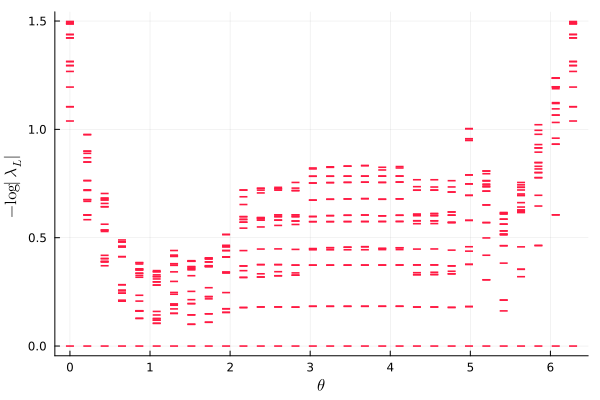

In [ ]:
fig = spectrumTransferMatrix(setθ2b, setData2b[1]["Psi"]; Nmax=20, scale=:log)
namesave="Spectrum_TransferMatrix_global2b"
Plots.png(fig, pathSave*namesave)
Plots.svg(fig, pathSave*namesave);

In [ ]:
# PlotCorrelationLength(setθ2b, setData2b[1]["Psi"])
fig = PlotCorrelationLength(setX, setθ2b, setRP2b)
display(fig)
namesave = "CorrelationLength_PhaseDiagram2b"
Plots.png(fig, pathSave*namesave)
Plots.svg(fig, pathSave*namesave);

### Phase Portrait

In [ ]:
fig = PhasePortait(setθ2b, setData2b)
namesave="Phase_portait_2body"
Plots.png(fig, pathSave*namesave)
Plots.svg(fig, pathSave*namesave);

### Overlap

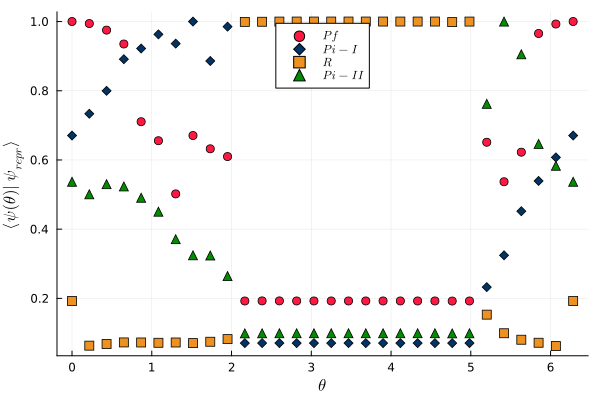

In [53]:
fig4 = overlap(setData2b[1]["Psi"], [1, 8, 16, 26], setθ2b)

### Entanglement spectrum

In [55]:
setInd = [1, 8, 16, 26]
setPsiRepr2b = [setData2b[1]["Psi"][ind] for ind in setInd];
setT2b = [setθ2b[ind] for ind in setInd];

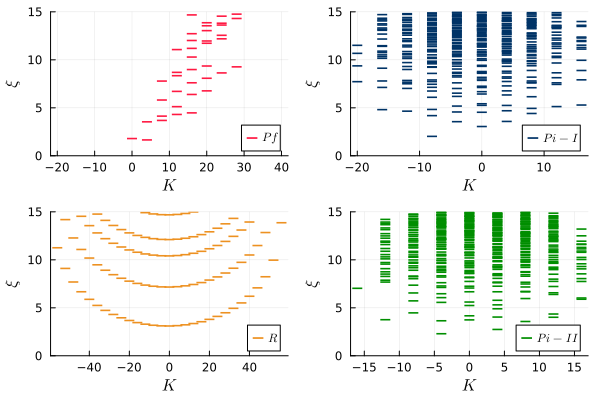

In [56]:
fig1 = plotReprPhase(setPsiRepr2b, setT2b, 0)
saveFig("Entanglement_spectrum_Phase_representant", fig1);

### structure factor

scale = :identity
fdssdfsdf


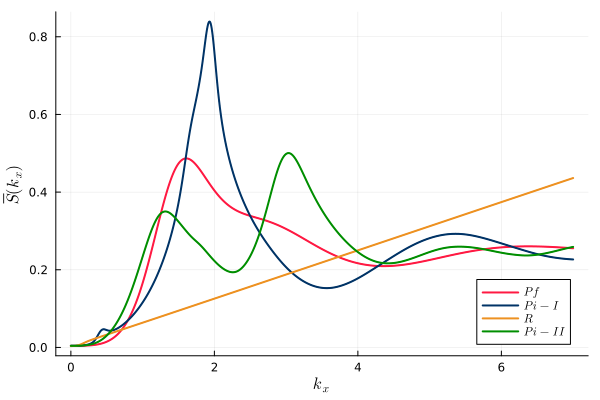

"FiguresNew\\StructureFactor_2body_globalRepr.svg"

In [57]:
fig2 = StructureFactor(setInd, setPsiRepr2b, setT2b, "Index"; scale=:identity)
display(fig2)
saveFig("StructureFactor_2body_globalRepr", fig2)


In [ ]:
StructureFactor(setX, setPsiRepr, setT, "bond"; indPsi=10)

### Average density

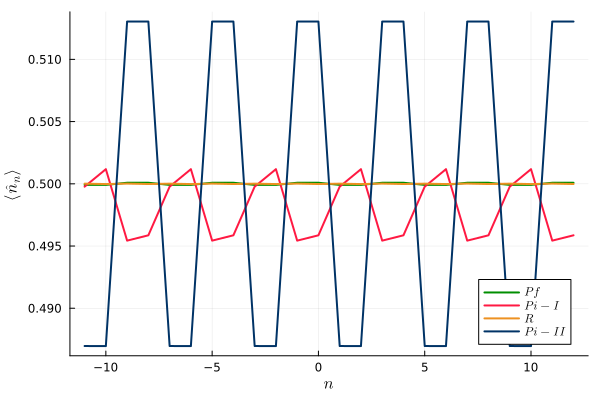

In [58]:
fig3 = DensityState(setInd, setPsiRepr2b, "Index"; sites=-11:12)
display(fig3)
saveFig("Density_global2b", fig3);

In [ ]:
DensityState(setX, setPsi, "bond"; sites=-11:12)
saveFig("Density")

### Pair Correlation function

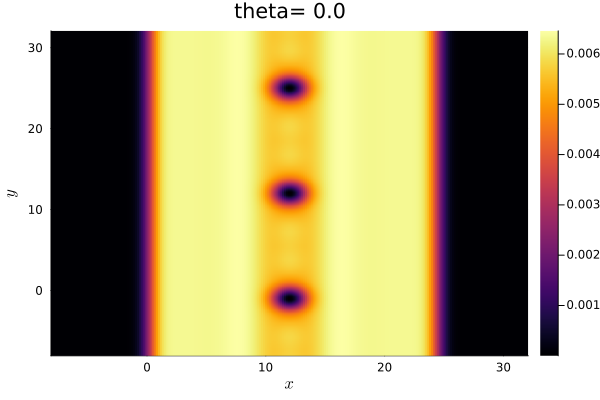

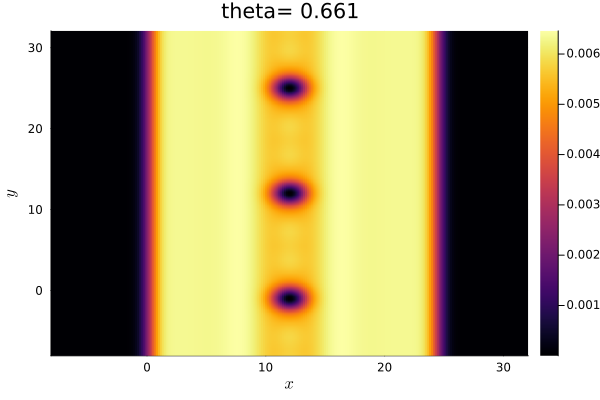

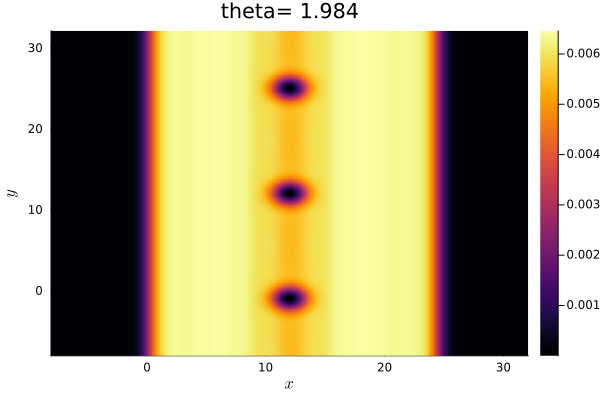

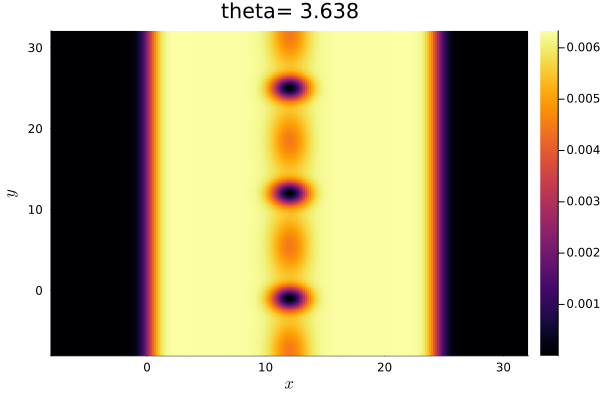

In [ ]:

for (ind, psi) in enumerate(setPsi)
    pairCorrelation(psi, L, setT[ind])
end

In [59]:
p = [fig4, fig2, fig3]
l = @layout [a; b c]
ff = plot(p..., layout = l, size=(900, 500))
saveFig("LayoutRepr_global2b", ff);

## Pf -> Pi-I

In [67]:
setRP_pi1 = [[2,2,1,1]]
L = 16. 
θmin = 1.5
θmax = 2.5
Nθ = 40
χmax = 4096
χ = 2048
typeInt = "2b_3b"
gap=true
flag=false
setIndPi_1 = [1, 8, 16, 26];
setXPi_1 = [256, 512, 1024, 2048, 4096];
setLegXi = [L"\chi=%$i" for i in setXPi_1]
setDataPi_1, setθPi_1 = loadData("phase", setRP_pi1);

2048
Sucessfuly load the data


### Correlation length

256
512
1024
2048
4096
missing 1.5 at index 1
missing 2.0128205128205128 at index 21
missing 2.1923076923076925 at index 28
missing 2.217948717948718 at index 29
missing 2.2435897435897436 at index 30
missing 2.269230769230769 at index 31
missing 2.2948717948717947 at index 32
missing 2.3205128205128203 at index 33
missing 2.3461538461538463 at index 34
missing 2.3717948717948723 at index 35
missing 2.3974358974358974 at index 36
missing 2.4230769230769234 at index 37
missing 2.448717948717949 at index 38
missing 2.474358974358974 at index 39
missing 2.5 at index 40


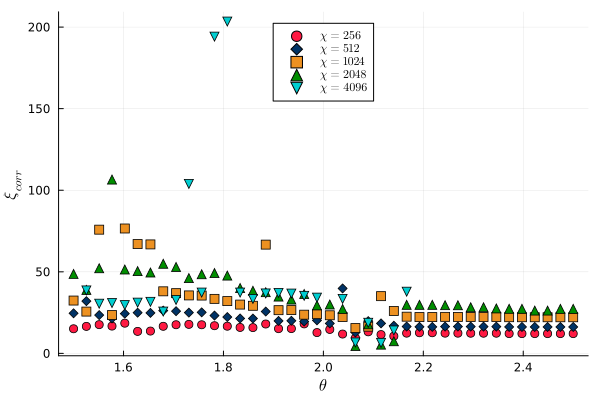

In [ ]:
PlotCorrelationLength(setXPi_1, setθPi_1, setRP_pi1, setLegXi)

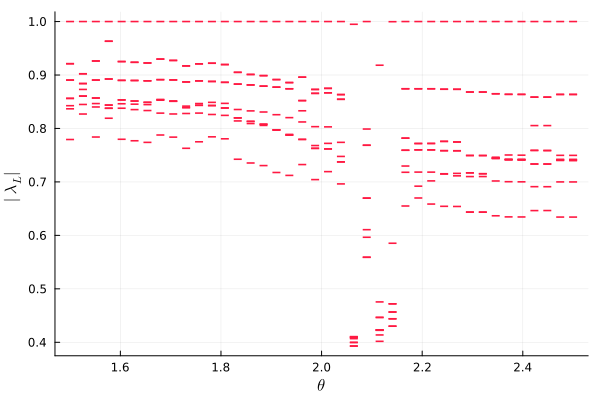

In [68]:
fig = spectrumTransferMatrix(setθPi_1, setDataPi_1[1]["Psi"])
saveFig("spectrumTransferMatrix_pi_1_2b_2048", fig);

In [72]:
fig = spectrumGap(setXPi_1, χmax, setθPi_1, L)
figGap = plot(fig..., layout = (2,1))

LoadError: UndefVarError: setRP not defined

256
512
1024
2048
4096
missing 1.5 at index 1
missing 2.0128205128205128 at index 21
missing 2.1923076923076925 at index 28
missing 2.217948717948718 at index 29
missing 2.2435897435897436 at index 30
missing 2.269230769230769 at index 31
missing 2.2948717948717947 at index 32
missing 2.3205128205128203 at index 33
missing 2.3461538461538463 at index 34
missing 2.3717948717948723 at index 35
missing 2.3974358974358974 at index 36
missing 2.4230769230769234 at index 37
missing 2.448717948717949 at index 38
missing 2.474358974358974 at index 39
missing 2.5 at index 40


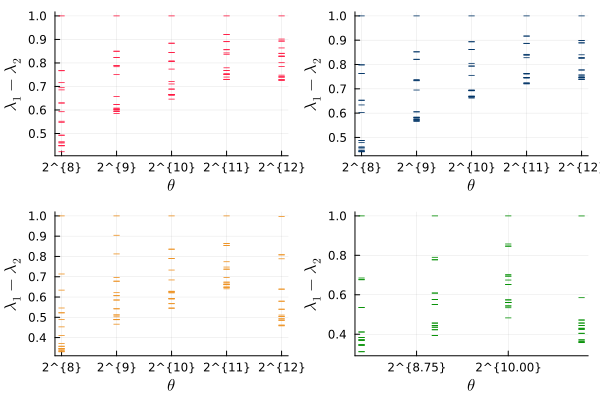

"FiguresNew\\Evolution_bondDim_EigenValueTranserMatrix_Pi1.svg"

In [71]:
fig = scalingSlice(setXPi_1, χmax, setθPi_1, L, [1, 10, 22, 26]);
saveFig("Evolution_bondDim_EigenValueTranserMatrix_Pi1", fig)

In [ ]:
fig = PhasePortait(setθPi_1, setDataPi_1)
display(fig)
saveFig("Phase_portait_2body_pi_1_R", fig)

## R -> Pi_1 -> Pf

In [ ]:
setRP = [[2,2,1,1]]
L = 16. 
θmin = 5.5
θmax = 6.4
Nθ = 40
χmax = 2048
χ = 4096
typeInt = "2b_3b"
gap=true
setIndex = [1, 8, 16, 26]

setX = Any[256, 512, 1024, 2048, 4096]

setDataL, setθL = loadData("phase", setRP);


4096
missing 5.523076923076923 at index 2
missing 5.86923076923077 at index 17
missing 5.892307692307693 at index 18
missing 5.915384615384616 at index 19
missing 5.938461538461539 at index 20
missing 5.961538461538462 at index 21
missing 5.984615384615385 at index 22
missing 6.007692307692308 at index 23
missing 6.030769230769231 at index 24
missing 6.053846153846154 at index 25
missing 6.076923076923077 at index 26
missing 6.1 at index 27
missing 6.1230769230769235 at index 28
missing 6.1461538461538465 at index 29
missing 6.169230769230769 at index 30
missing 6.1923076923076925 at index 31
missing 6.2153846153846155 at index 32
missing 6.2384615384615385 at index 33
missing 6.261538461538462 at index 34
missing 6.284615384615385 at index 35
missing 6.307692307692308 at index 36
missing 6.3307692307692305 at index 37
missing 6.3538461538461535 at index 38
missing 6.376923076923077 at index 39
missing 6.4 at index 40
Sucessfuly load the data


In [ ]:
setX = Any[256, 512, 1024, 2048, 4096]
fig = PlotCorrelationLength(setX, setθL, setRP; chiMax=2048)
display(fig)
namesave = "CorrelationLengthSecondInvPhase_2b"
Plots.png(fig, pathSave*namesave)
Plots.svg(fig, pathSave*namesave);


LoadError: UndefVarError: setθL not defined

In [ ]:
fig = PhasePortait(setθL, setDataL)
display(fig)
namesave="Phase_portait_2body"
Plots.png(fig, pathSave*namesave)
Plots.svg(fig, pathSave*namesave);

LoadError: UndefVarError: setθL not defined

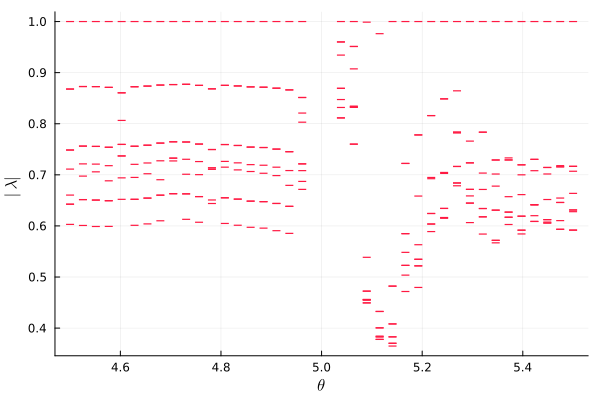

In [ ]:
fig = spectrumTransferMatrix(setθL, setDataL[1]["Psi"])
namesave="Spectrum_transferMatrix$(χ)"
Plots.png(fig, pathSave*namesave)
Plots.svg(fig, pathSave*namesave);

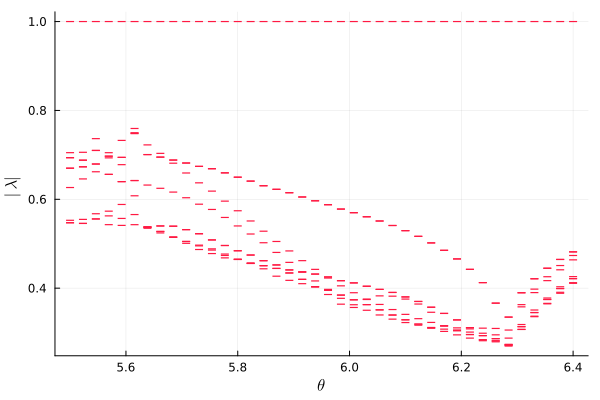

In [ ]:
fig = spectrumTransferMatrix(setθL, setDataL[1]["Psi"])
namesave="EIGENSTest"
Plots.png(fig, pathSave*namesave)
Plots.svg(fig, pathSave*namesave);

## Pfaffian

In [ ]:
setRP = [[2,2,1,1], [2,1,2,1]]
Lmin = 15.
Lmax = 22.
NL = 15
θ = 0.0
Nθ = 1
χmax = 4096
χ = 4096
typeInt = "2b_3b"
gap=true
flag = false
setInd = [1, 8, 16, 26]
setChi = [256, 512, 1024, 2048, 4096]


setDataPf, setLPf = loadData("Length", setRP);


4096
4096
Sucessfuly load the data


### Topological Entanglement Entropy

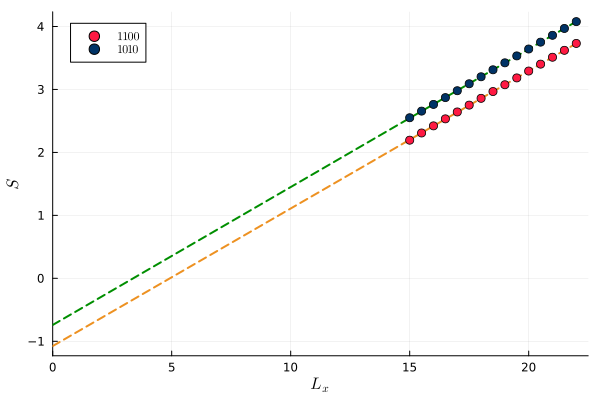

In [ ]:
S, fig = TEE(setLPf, setDataPf; N=4, returnPlot=true)
namesave = "TEE_pfaffian_chi4096"
Plots.png(fig, pathSave*namesave)
Plots.svg(fig, pathSave*namesave);

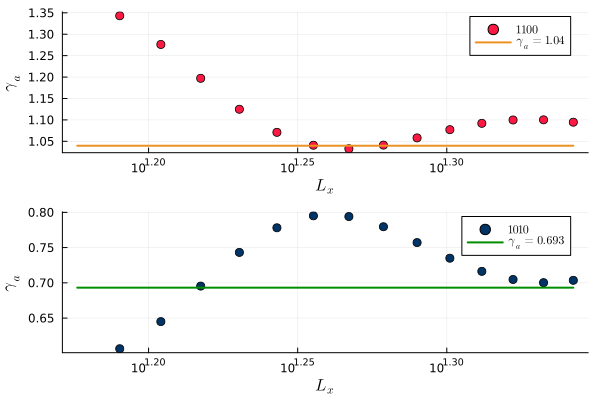

In [ ]:
p = [TEE(setLPf, setDataPf, i; N= 1,returnPlot=true) for i=1:2]
fig = plot(p..., layout=(2,1))
display(fig)
namesave = "DistanceToTEE_pfaff_chi4096"
Plots.png(fig, pathSave*namesave)
Plots.svg(fig, pathSave*namesave);

In [ ]:
estimation_TEE(setChi, setLPf)

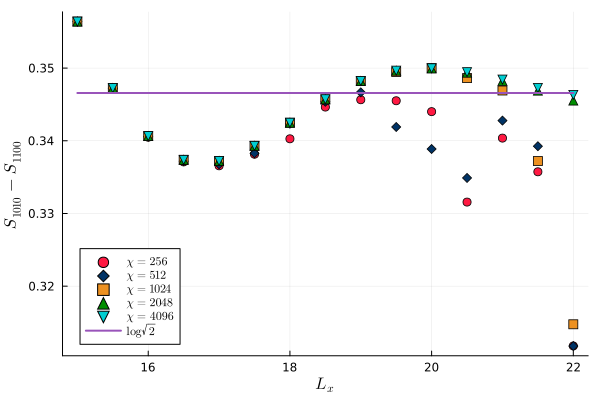

In [ ]:
fig = Diff_TeeBond(setChi, setLPf, setRP);
namesave = "DiffTEE_bond_Pfaffian"
Plots.png(fig, pathSave*namesave)
Plots.svg(fig, pathSave*namesave);

### Entanglement spectrum

In [ ]:
fig1 = plotAllEnt(setDataPf, 1, setLPf);
namesave1 = "Ent_spectrum_L22_1100_chi4096_high"

fig2 = plotAllEnt(setDataPf, 2, setLPf);
namesave2 = "Ent_spectrum_L22_1010_chi4096_high"

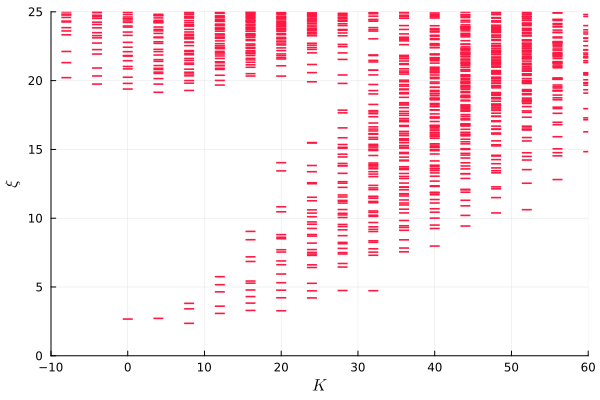

"FiguresNew\\LargeEntSpectrum_Pfaffian.svg"

In [ ]:
figEnt = singleEntanglementSpectrum(setDataPf[1]["Psi"][15], 1);
saveFig("LargeEntSpectrum_Pfaffian", figEnt)

### Correlation length 

MatrixL = [[0.06666666666666667, 0.06451612903225806, 0.0625, 0.06060606060606061, 0.058823529411764705, 0.05714285714285714, 0.05555555555555555, 0.05405405405405406, 0.05263157894736842, 0.05128205128205128, 0.05, 0.04878048780487805, 0.047619047619047616, 0.046511627906976744, 0.045454545454545456], [0.06666666666666667, 0.06451612903225806, 0.0625, 0.06060606060606061, 0.058823529411764705, 0.05714285714285714, 0.05555555555555555, 0.05405405405405406, 0.05263157894736842, 0.05128205128205128, 0.05, 0.04878048780487805, 0.047619047619047616, 0.046511627906976744, 0.045454545454545456]]
typeof(MatrixL) = Vector{Vector{Float64}}


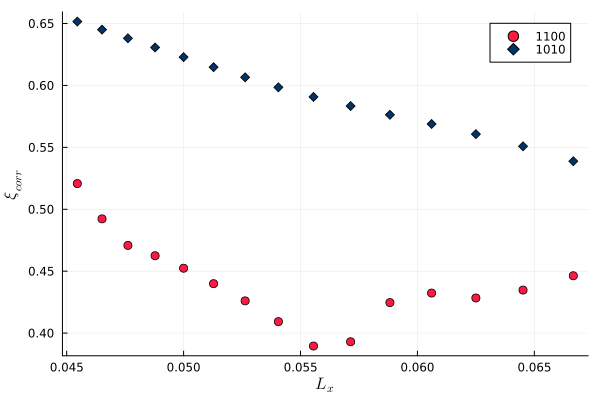

In [ ]:
PlotCorrelationLength(setLPf, setDataPf);

### Fidelty with higher length

### Dehn twist

topologicalshift = 2
topologicalshift = 1


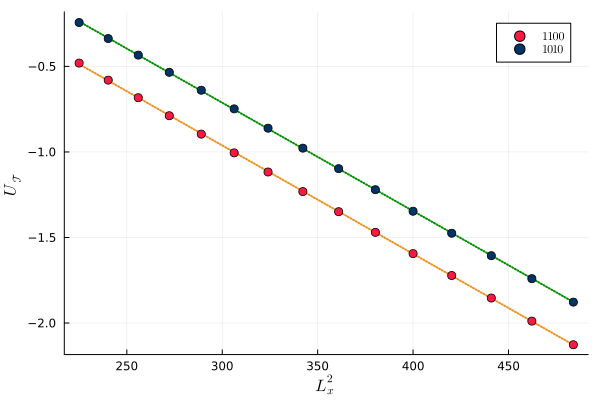

In [ ]:
_, fig = DehnTwist(setLPf, setDataPf)
namesave = "DehnTwist_pfaffian"
Plots.png(fig, pathSave*namesave)
Plots.svg(fig, pathSave*namesave);

In [ ]:
fig = estimation(setLPf, setChi, setRP)
display(fig)
namesave = "Estimation_topoDehnTwist_pfaff"
Plots.png(fig, pathSave*namesave)
Plots.svg(fig, pathSave*namesave);

256
256
c = -2.352819024748829
512
512
c = -1.9716613768089646
1024
1024
c = -1.6274400483853793
2048
2048
c = -1.4780748193501259
4096
4096
c = -1.4771858954096029


## Middle phase

In [ ]:
setRP = [[1,2,1,1,2,1]]
L = 12.
θmin = 0
θmax = 2pi
Nθ = 20
χmax = 1024
χ = 512
typeInt = "2b_3b"
gap=true;
setIndex = [1, 5, 12, 18];

setDatav13, setLPfv13 = loadData("phase", setRP);

512
missing 6.283185307179586 at index 20
Sucessfuly load the data


No 0 sector
No 0 sector
No 0 sector
No 0 sector
No 0 sector
No 0 sector
No 0 sector
No 0 sector

┌ Warning: Invariant subspace of dimension 1 (up to requested tolerance `tol = 1.0e-10`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 2`); setting `howmany = 1`.
└ @ KrylovKit C:\Users\basil\.julia\packages\KrylovKit\diNbc\src\eigsolve\arnoldi.jl:200


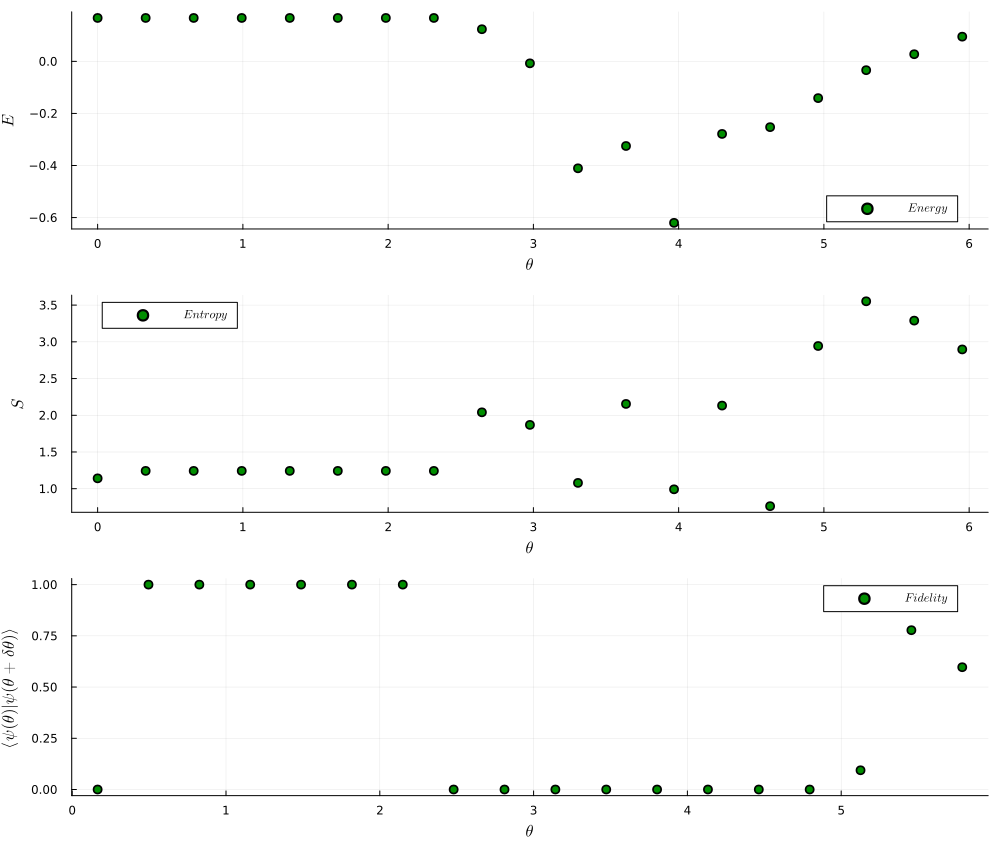

In [ ]:
fig = PhasePortait(setLPfv13, setDatav13)

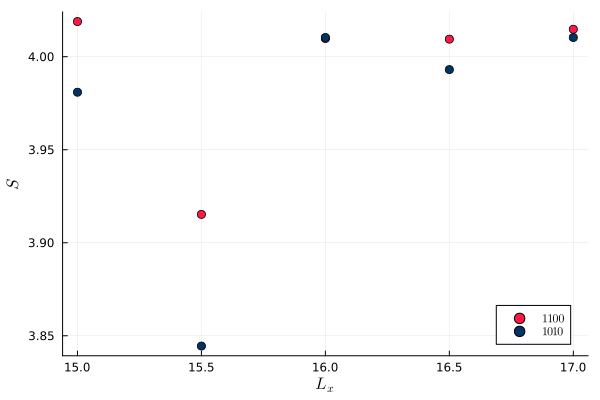

2-element Vector{Float64}:
 3.7187185662894624
 3.3039898928563343

In [ ]:
aS1, S2 = TEE(setLMid2b, setDataMid2b; plotFit=false)

## Pi-II

In [ ]:
setRP = [[2,2,1,1], [2,1,2,1]]
Lmin = 15
Lmax = 20.
NL = 11
θ = 5.35
Nθ = 1
χmax = 2048
χ = 2048
typeInt = "2b_3b"
gap=true
flag = false
setInd = [1, 8, 16, 26]
setChi = [256, 512, 1024, 2048, 4096]

setDataPf, setLPf = loadData("Length", setRP);

2048
2048
missing 16.5 at index 4
missing 17.0 at index 5
missing 17.5 at index 6
missing 18.0 at index 7
missing 18.5 at index 8
Sucessfuly load the data


In [ ]:
fig = PhasePortait(setθ2b, setData2b)
display(fig)
namesave="Phase_portait_2body"
Plots.png(fig, pathSave*namesave)
Plots.svg(fig, pathSave*namesave);

# Four Body - Three Body interaction

## Phase portait

In [ ]:
setRP3b_ = [[2,1,2,1]]
L = 13.
θmin = 0
θmax = 2pi
Nθ = 20
χmax = 2048
χ = 512
typeInt = "3b_4b"
gap=false;
setIndex = [1, 3, 7, 12];

setData3b, setθ3b = loadData("phase", setRP3b_);



512
missing 1.6534698176788385 at index 6
Sucessfuly load the data


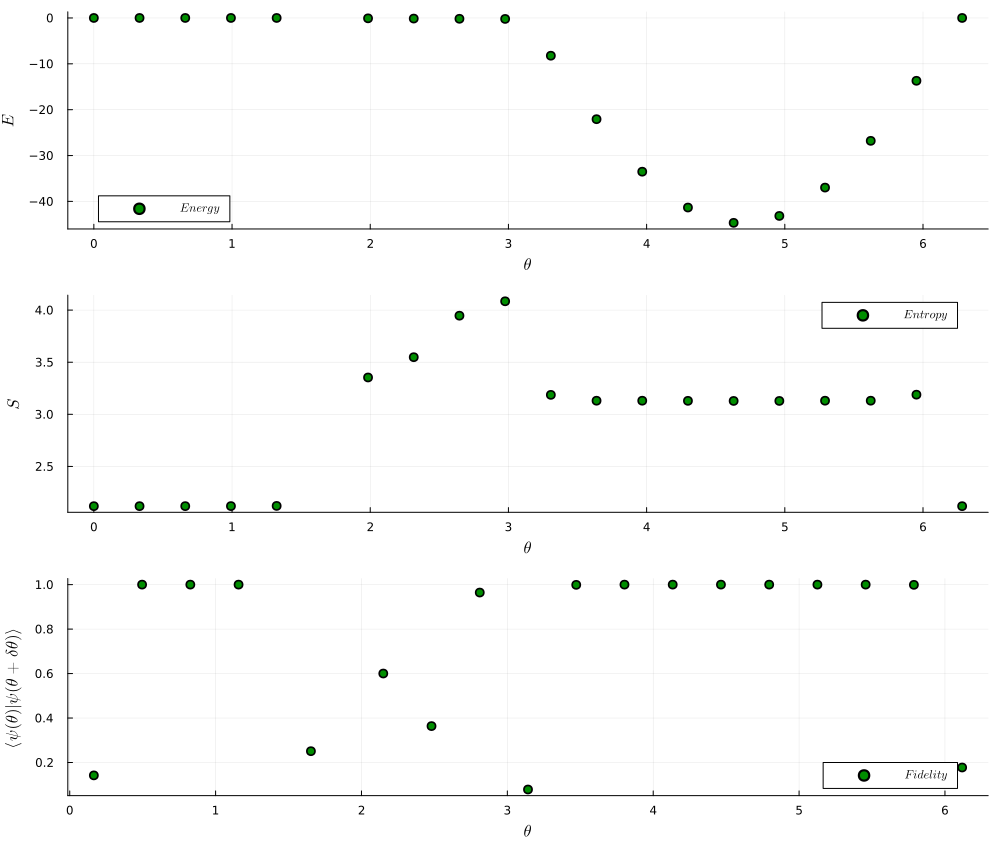

In [ ]:
PhasePortait(setθ3b, setData3b)

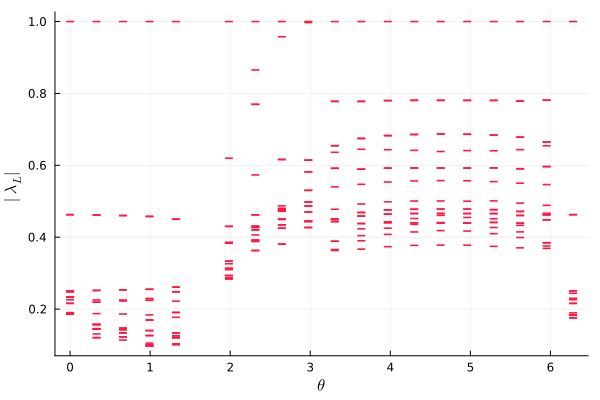

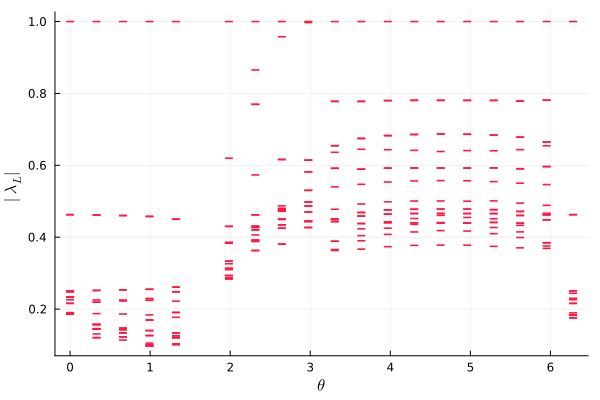

In [ ]:
fig = spectrumTransferMatrix(setθ3b, setData3b[1]["Psi"]; Nmax=20, scale=:identity)

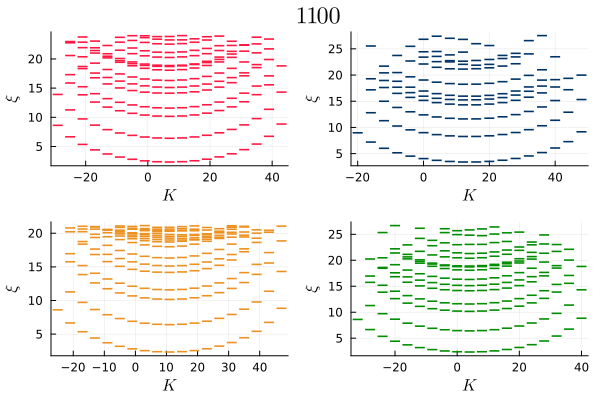

In [ ]:
plotAllEnt(setData3b, 1, setθ3b;indexlook=10);

## Middle Phase

In [ ]:
setRP = [[2,2,1,1], [2,1,2,1]]
Lmin = 7
Lmax = 10
NL =7
θ = 2.5
Nθ = 1
χmax = 4096
χ = 512
typeInt = "3b_4b"
gap=true
flag = false
setInd = [1, 8, 16, 26]
setChi = [256, 512, 1024, 2048]


ColorsLoc = [RGB(1., 0.1, 0.26), RGB(0.0, 0.2, 0.4), RGB(0.93, 0.57, 0.13), RGB(0., 0.56, 0.)]
Nstep = 1

setData3BM, setL3BM = loadData("Length", setRP);


Sucessfuly load the data


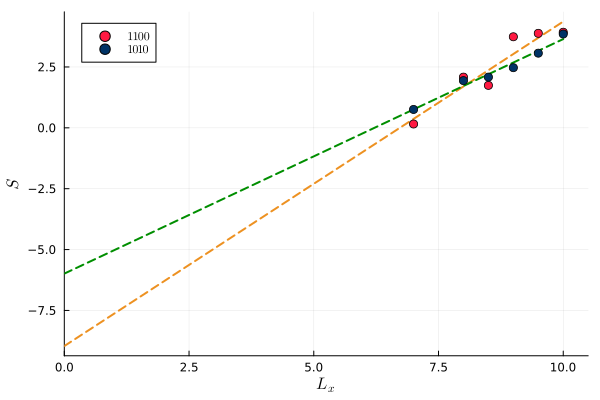

2-element Vector{Float64}:
 -8.962271060179072
 -5.987123605096713

In [ ]:
S1, S2 = TEE(setL3BM, setData3BM)


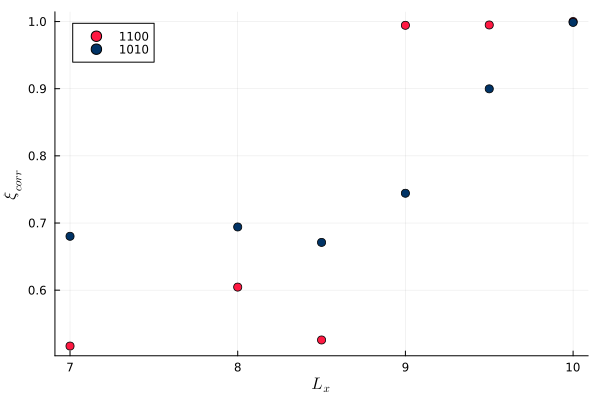

In [ ]:
PlotCorrelationLength(setL3BM, setData3BM)

newsetL = [49.0, 64.0, 72.25, 81.0, 90.25, 100.0]
DTarray = Any[[0.4792138789568397, 0.36402145387835105, 0.3918090770016036, 0.118479718110942, 0.18455094719788456, 0.31452523226870205], [0.44891756314045494, 0.9856746473062613, 0.7384228208538439, 0.5338614530615378, 0.48110288309091986, 0.8937191176551169]]


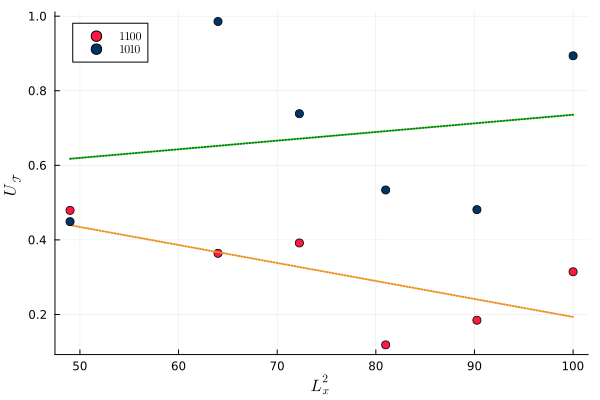

(Any[(0.6758853277448652, -0.004825217215892387), (0.5040904538445693, 0.0023157848018416556)], Plot{Plots.GRBackend() n=4})

In [ ]:
DehnTwist(setL3BM, setData3BM)

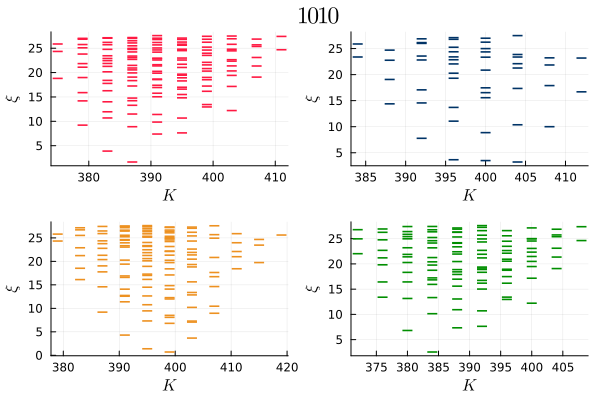

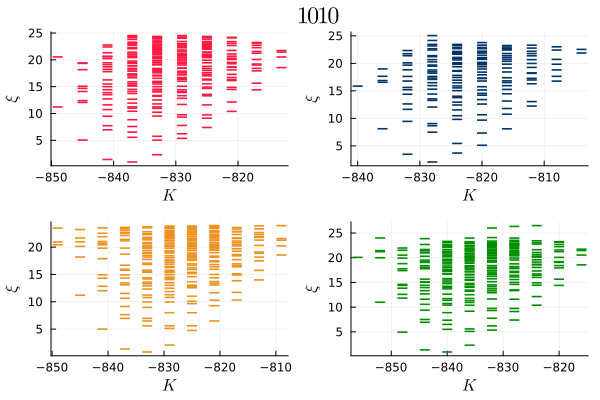

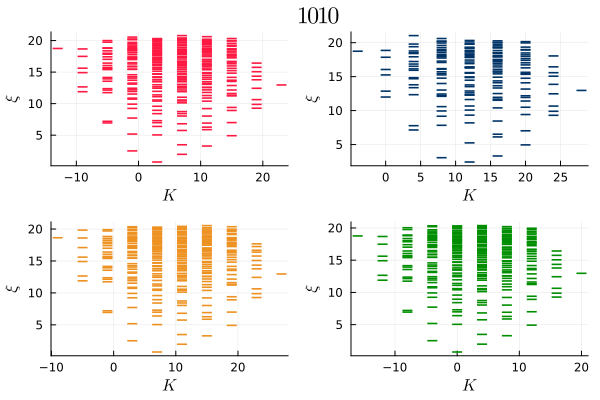

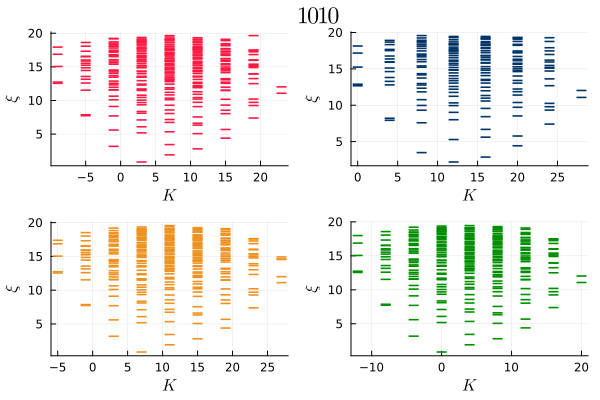

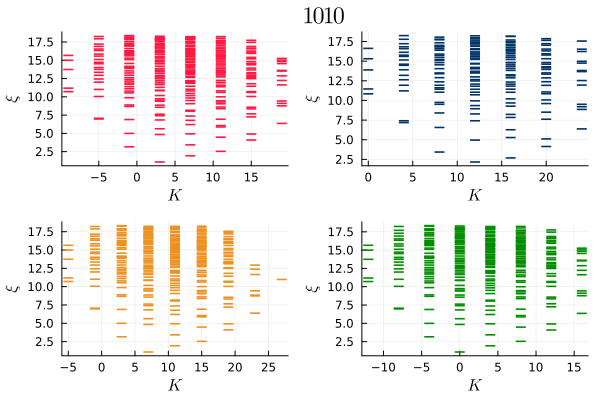

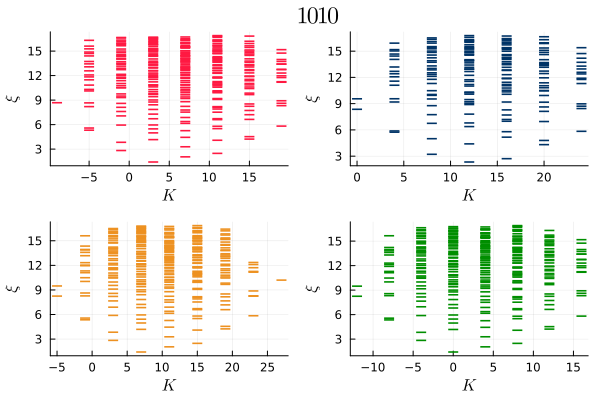

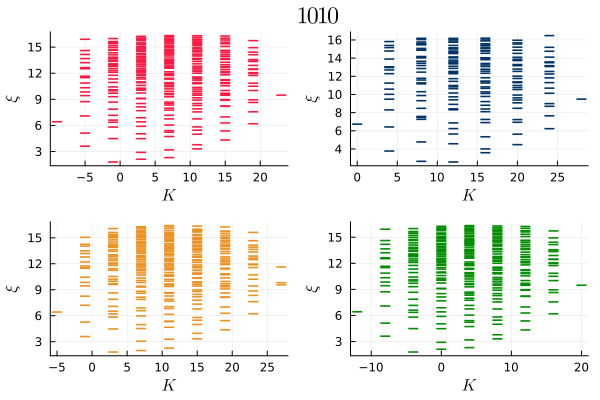

LoadError: UndefVarError: fig not defined

In [ ]:
plotAllEnt(setData3BM, 2, setL3BM);